## NBA Player Performance Analysis - Ayo Dosunmu

This project analyzes Ayo Dosunmu's performance with the Chicago Bulls over time. We will explore various statistics to understand his development and contributions to the team.

### Data Collection

In [32]:
# Import libraries
!pip install nba_api

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from nba_api.stats.endpoints import playergamelog, leaguegamefinder

In [33]:
# Get Ayo's stats
PLAYER_ID = 1630245

def fetch_nba_data(player_id):
    gamelog = playergamelog.PlayerGameLog(player_id=player_id, season="2024-25", season_type_all_star="Regular Season")
    df = gamelog.get_data_frames()[0]
    return df

ayo_stats_df = fetch_nba_data(PLAYER_ID)

# Change format of GAME_DATE column -- create new column 'Date'
ayo_stats_df["Date"] = pd.to_datetime(ayo_stats_df["GAME_DATE"], format="%b %d, %Y")

# Convert to desired string format (YYYY-MM-DD)
ayo_stats_df["Date"] = ayo_stats_df["Date"].dt.strftime("%Y-%m-%d")

print(ayo_stats_df.head())
ayo_stats_df.to_csv("ayo_live_data.csv", index=False)

  SEASON_ID  Player_ID     Game_ID     GAME_DATE      MATCHUP WL  MIN  FGM  \
0     22024    1630245  0022400695  FEB 02, 2025    CHI @ DET  L   32    6   
1     22024    1630245  0022400682  JAN 31, 2025    CHI @ TOR  W   35    2   
2     22024    1630245  0022400666  JAN 29, 2025    CHI @ BOS  L   32    5   
3     22024    1630245  0022400655  JAN 27, 2025  CHI vs. DEN  W   34    6   
4     22024    1630245  0022400642  JAN 25, 2025  CHI vs. PHI  L   28    3   

   FGA  FG_PCT  ...  REB  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  \
0    9   0.667  ...    3    5    0    1    3   3   14         -11   
1    9   0.222  ...    4    8    1    1    1   1    6          10   
2   13   0.385  ...    4    4    1    0    1   2   12         -23   
3   13   0.462  ...    2    2    2    1    2   1   17          20   
4   10   0.300  ...    2    2    0    0    2   2    8         -10   

   VIDEO_AVAILABLE        Date  
0                1  2025-02-02  
1                1  2025-01-31  
2                

In [34]:
# Get Bulls game stats
BULLS_TEAM_ID = 1610612741  

# Fetch all games for the Bulls in the 2024-25 season
game_finder = leaguegamefinder.LeagueGameFinder(
    team_id_nullable=BULLS_TEAM_ID, 
    season_nullable="2024-25"
)
games_df = game_finder.get_data_frames()[0]  # Convert to Pandas DataFrame

# Display first few rows
print(games_df.head())

# Save to CSV
games_df.to_csv("bulls_games_2024_25.csv", index=False)

  SEASON_ID     TEAM_ID TEAM_ABBREVIATION      TEAM_NAME     GAME_ID  \
0     22024  1610612741               CHI  Chicago Bulls  0022400695   
1     22024  1610612741               CHI  Chicago Bulls  0022400682   
2     22024  1610612741               CHI  Chicago Bulls  0022400666   
3     22024  1610612741               CHI  Chicago Bulls  0022400655   
4     22024  1610612741               CHI  Chicago Bulls  0022400642   

    GAME_DATE      MATCHUP WL  MIN  PTS  ...  FT_PCT  OREB  DREB  REB  AST  \
0  2025-02-02    CHI @ DET  L  241  119  ...   0.900    11    33   44   28   
1  2025-01-31    CHI @ TOR  W  240  122  ...   0.824     9    43   52   34   
2  2025-01-29    CHI @ BOS  L  242  100  ...   0.917    10    37   47   28   
3  2025-01-27  CHI vs. DEN  W  240  129  ...   0.875    13    34   47   35   
4  2025-01-25  CHI vs. PHI  L  240   97  ...   0.650    13    41   54   24   

   STL  BLK  TOV  PF  PLUS_MINUS  
0    7    4   19  11        -8.0  
1    4    9   10  18        

### Data Cleaning & Transformation

In [35]:
ayo_stats_df.dropna(subset=['PTS'], inplace=True)  # Drop rows without points data
ayo_stats_df['PTS'] = ayo_stats_df['PTS'].astype(int)  # Convert points to integer
ayo_stats_df['Home/Away'] = ayo_stats_df['MATCHUP'].apply(lambda x: 'Away' if '@' in x else 'Home')

# Rename columns for consistency
ayo_stats_df.rename(columns={'MATCHUP': 'Opponent', 'WL': 'Win/Loss'}, inplace=True)

games_df.dropna(subset=['PTS'], inplace=True)  # Drop rows without points data
games_df['PTS'] = games_df['PTS'].astype(int)  # Convert points to integer
games_df['Home/Away'] = games_df['MATCHUP'].apply(lambda x: 'Away' if '@' in x else 'Home')

# Select relevant columns
games_df = games_df[['GAME_DATE', 'MATCHUP', 'Home/Away', 'PTS', 'WL']]

# Rename columns for consistency
games_df.rename(columns={'GAME_DATE': 'Date', 'MATCHUP': 'Opponent', 'WL': 'Win/Loss'}, inplace=True)

# Save cleaned dataset
games_df.to_csv("cleaned_bulls_games_2024_25.csv", index=False)

print("Cleaned Data Sample:")
print(games_df.head())

Cleaned Data Sample:
         Date     Opponent Home/Away  PTS Win/Loss
0  2025-02-02    CHI @ DET      Away  119        L
1  2025-01-31    CHI @ TOR      Away  122        W
2  2025-01-29    CHI @ BOS      Away  100        L
3  2025-01-27  CHI vs. DEN      Home  129        W
4  2025-01-25  CHI vs. PHI      Home   97        L


In [36]:
# ---- Function to Load Team Results ---- #
def load_team_results(filepath):
    team_results_df = pd.read_csv(filepath)
    team_results_df = team_results_df[['Date', 'Opponent', 'PTS', 'Win/Loss', 'Home/Away']]
    return team_results_df

team_results = load_team_results('cleaned_bulls_games_2024_25.csv')

In [37]:
# ---- Function to Merge with Player Stats ---- #
def merge_datasets(player_df, team_df):
    merged_df = pd.merge(player_df, team_df, on='Date', how='left')
    return merged_df

# Merge Ayo Dosunmu's stats with team results
print(ayo_stats_df.head())
ayo_merged_df = merge_datasets(ayo_stats_df, team_results)

# Save merged dataset
ayo_merged_df.to_csv("ayo_bulls_merged_stats.csv", index=False)

print("\nMerged Data Sample:")
print(ayo_merged_df.head())

  SEASON_ID  Player_ID     Game_ID     GAME_DATE     Opponent Win/Loss  MIN  \
0     22024    1630245  0022400695  FEB 02, 2025    CHI @ DET        L   32   
1     22024    1630245  0022400682  JAN 31, 2025    CHI @ TOR        W   35   
2     22024    1630245  0022400666  JAN 29, 2025    CHI @ BOS        L   32   
3     22024    1630245  0022400655  JAN 27, 2025  CHI vs. DEN        W   34   
4     22024    1630245  0022400642  JAN 25, 2025  CHI vs. PHI        L   28   

   FGM  FGA  FG_PCT  ...  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  \
0    6    9   0.667  ...    5    0    1    3   3   14         -11   
1    2    9   0.222  ...    8    1    1    1   1    6          10   
2    5   13   0.385  ...    4    1    0    1   2   12         -23   
3    6   13   0.462  ...    2    2    1    2   1   17          20   
4    3   10   0.300  ...    2    0    0    2   2    8         -10   

   VIDEO_AVAILABLE        Date  Home/Away  
0                1  2025-02-02       Away  
1                1  20

### Exploratory Data Analysis

In [38]:
# Display basic info
print("\nDataset Info:")
print(ayo_merged_df.info())

# Display first few rows
print("\nSample Data:")
print(ayo_merged_df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SEASON_ID        39 non-null     object 
 1   Player_ID        39 non-null     int64  
 2   Game_ID          39 non-null     object 
 3   GAME_DATE        39 non-null     object 
 4   Opponent_x       39 non-null     object 
 5   Win/Loss_x       39 non-null     object 
 6   MIN              39 non-null     int64  
 7   FGM              39 non-null     int64  
 8   FGA              39 non-null     int64  
 9   FG_PCT           39 non-null     float64
 10  FG3M             39 non-null     int64  
 11  FG3A             39 non-null     int64  
 12  FG3_PCT          39 non-null     float64
 13  FTM              39 non-null     int64  
 14  FTA              39 non-null     int64  
 15  FT_PCT           39 non-null     float64
 16  OREB             39 non-null     int64  
 17  DRE

In [39]:
# Check for missing values
print("\nMissing Values:")
print(ayo_merged_df.isnull().sum())


Missing Values:
SEASON_ID          0
Player_ID          0
Game_ID            0
GAME_DATE          0
Opponent_x         0
Win/Loss_x         0
MIN                0
FGM                0
FGA                0
FG_PCT             0
FG3M               0
FG3A               0
FG3_PCT            0
FTM                0
FTA                0
FT_PCT             0
OREB               0
DREB               0
REB                0
AST                0
STL                0
BLK                0
TOV                0
PF                 0
PTS_x              0
PLUS_MINUS         0
VIDEO_AVAILABLE    0
Date               0
Home/Away_x        0
Opponent_y         0
PTS_y              0
Win/Loss_y         0
Home/Away_y        0
dtype: int64


In [40]:
# Drop unnecessary columns
columns_to_drop = ['Opponent_y', 'PTS_y', 'Win/Loss_y', 'Home/Away_y']
ayo_merged_df.drop(columns=columns_to_drop, inplace=True)

# Rename columns for clarity
column_renaming = {
    'Opponent_x': 'Opponent',
    'Win/Loss_x': 'Win/Loss',
    'PTS_x': 'PTS',
    'Home/Away_x': 'Home/Away'
}

ayo_merged_df.rename(columns=column_renaming, inplace=True)

# Display the cleaned dataset
print(ayo_merged_df.head())

  SEASON_ID  Player_ID     Game_ID     GAME_DATE     Opponent Win/Loss  MIN  \
0     22024    1630245  0022400695  FEB 02, 2025    CHI @ DET        L   32   
1     22024    1630245  0022400682  JAN 31, 2025    CHI @ TOR        W   35   
2     22024    1630245  0022400666  JAN 29, 2025    CHI @ BOS        L   32   
3     22024    1630245  0022400655  JAN 27, 2025  CHI vs. DEN        W   34   
4     22024    1630245  0022400642  JAN 25, 2025  CHI vs. PHI        L   28   

   FGM  FGA  FG_PCT  ...  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  \
0    6    9   0.667  ...    5    0    1    3   3   14         -11   
1    2    9   0.222  ...    8    1    1    1   1    6          10   
2    5   13   0.385  ...    4    1    0    1   2   12         -23   
3    6   13   0.462  ...    2    2    1    2   1   17          20   
4    3   10   0.300  ...    2    0    0    2   2    8         -10   

   VIDEO_AVAILABLE        Date  Home/Away  
0                1  2025-02-02       Away  
1                1  20

In [41]:
# Get descriptive statistics
print("\nSummary Statistics:")
print(ayo_merged_df.describe())


Summary Statistics:
       Player_ID        MIN        FGM        FGA     FG_PCT       FG3M  \
count       39.0  39.000000  39.000000  39.000000  39.000000  39.000000   
mean   1630245.0  30.564103   4.743590   9.820513   0.489103   1.435897   
std          0.0   4.197712   2.220929   2.458838   0.194826   1.020703   
min    1630245.0  23.000000   1.000000   6.000000   0.091000   0.000000   
25%    1630245.0  27.500000   3.000000   8.000000   0.359000   1.000000   
50%    1630245.0  31.000000   4.000000  10.000000   0.500000   1.000000   
75%    1630245.0  33.000000   6.000000  12.000000   0.667000   2.000000   
max    1630245.0  40.000000  10.000000  15.000000   0.833000   4.000000   

            FG3A    FG3_PCT        FTM        FTA  ...       DREB        REB  \
count  39.000000  39.000000  39.000000  39.000000  ...  39.000000  39.000000   
mean    4.205128   0.332513   1.307692   1.666667  ...   3.051282   3.692308   
std     1.962537   0.245487   1.794052   1.896442  ...   1.8201

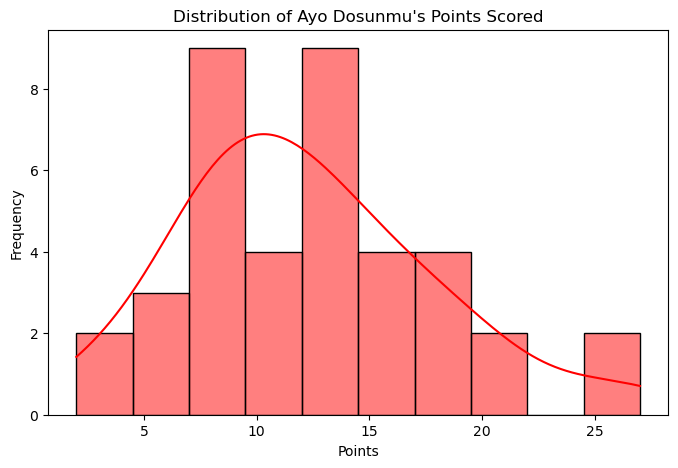

In [42]:
# Histogram of points scored by Ayo Dosunmu
plt.figure(figsize=(8,5))
sns.histplot(ayo_merged_df['PTS'], bins=10, kde=True, color='red')
plt.title("Distribution of Ayo Dosunmu's Points Scored")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.show()

/var/folders/b_/xl1x_5ss2dn8k8259w7prh_40000gn/T/ipykernel_47444/1669916534.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Home/Away', y='PTS', data=ayo_merged_df, palette={'Home': 'blue', 'Away': 'orange'})


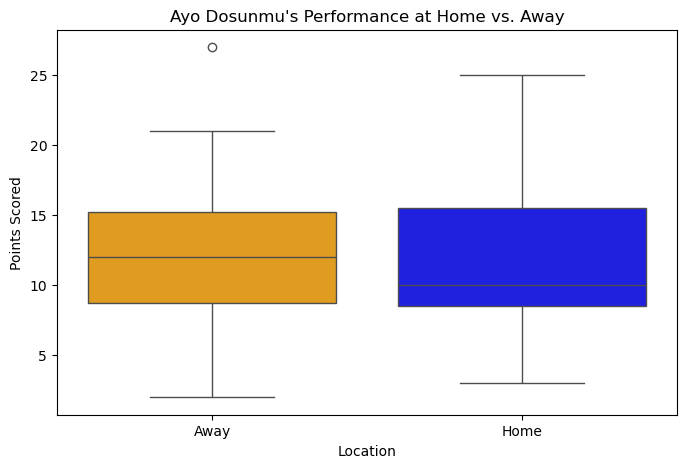


Average Points Per Game:
Home/Away
Away    12.45
Home    12.00
Name: PTS, dtype: float64


In [43]:
# Boxplot of points scored at home vs. away
plt.figure(figsize=(8,5))
sns.boxplot(x='Home/Away', y='PTS', data=ayo_merged_df, palette={'Home': 'blue', 'Away': 'orange'})
plt.title("Ayo Dosunmu's Performance at Home vs. Away")
plt.xlabel("Location")
plt.ylabel("Points Scored")
plt.show()

# Mean points per game (PPG) home vs. away
home_away_avg = ayo_merged_df.groupby("Home/Away")["PTS"].mean()
print("\nAverage Points Per Game:")
print(home_away_avg)

/var/folders/b_/xl1x_5ss2dn8k8259w7prh_40000gn/T/ipykernel_47444/1660635809.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Win/Loss', y='PTS', data=ayo_merged_df, palette={'W': 'green', 'L': 'red'})


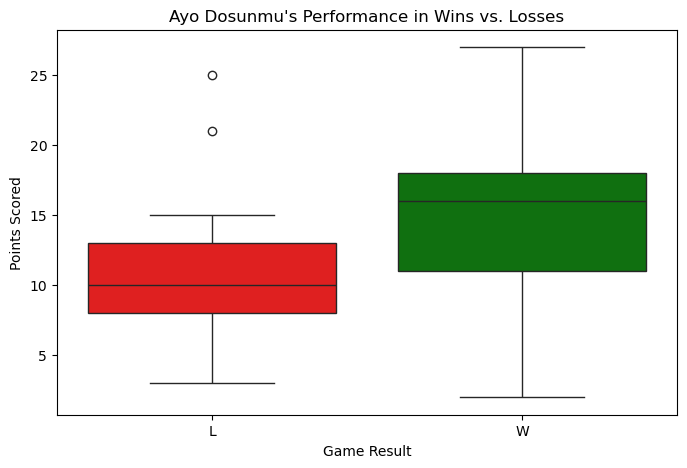


Average Points Per Game in Wins vs. Losses:
Win/Loss
L    10.958333
W    14.266667
Name: PTS, dtype: float64


In [44]:
# Boxplot of points scored in wins vs. losses
plt.figure(figsize=(8,5))
sns.boxplot(x='Win/Loss', y='PTS', data=ayo_merged_df, palette={'W': 'green', 'L': 'red'})
plt.title("Ayo Dosunmu's Performance in Wins vs. Losses")
plt.xlabel("Game Result")
plt.ylabel("Points Scored")
plt.show()

# Average points in wins vs. losses
win_loss_avg = ayo_merged_df.groupby("Win/Loss")["PTS"].mean()
print("\nAverage Points Per Game in Wins vs. Losses:")
print(win_loss_avg)

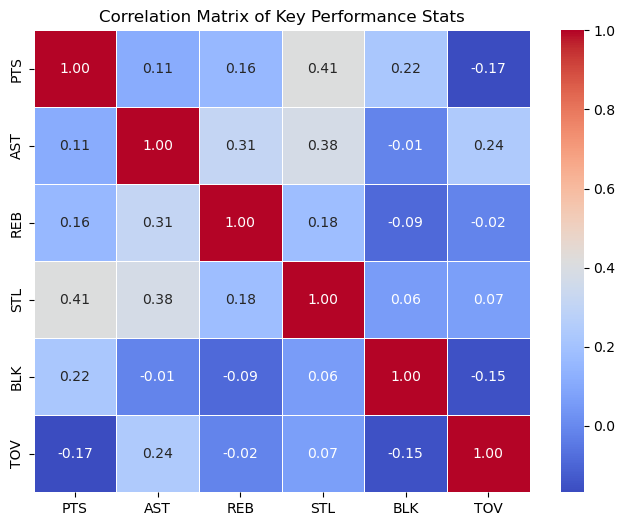

In [45]:
# Compute correlation matrix
corr_matrix = ayo_merged_df[['PTS', 'AST', 'REB', 'STL', 'BLK', 'TOV']].corr()

# Heatmap of correlations
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Key Performance Stats")
plt.show()

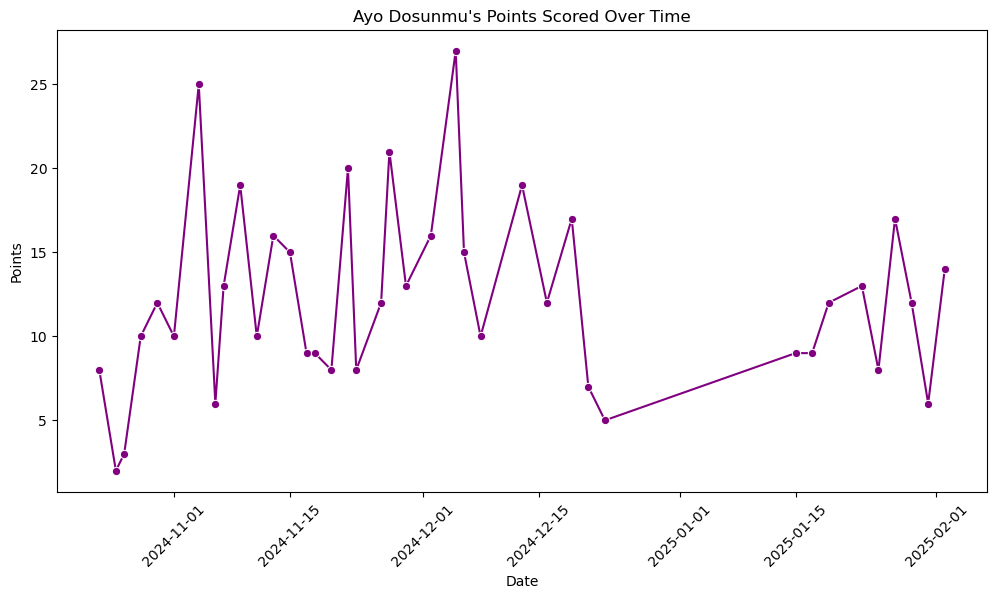

In [46]:
# Convert 'Date' column to datetime for time series analysis
ayo_merged_df['Date'] = pd.to_datetime(ayo_merged_df['Date'])

# Line plot of points scored over time
plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='PTS', data=ayo_merged_df, marker="o", color='purple')
plt.xticks(rotation=45)
plt.title("Ayo Dosunmu's Points Scored Over Time")
plt.xlabel("Date")
plt.ylabel("Points")
plt.show()

### Advanced Analytics & Machine Learning

Mean Absolute Error: 2.8802716782365794
R² Score: 0.4523757714810046


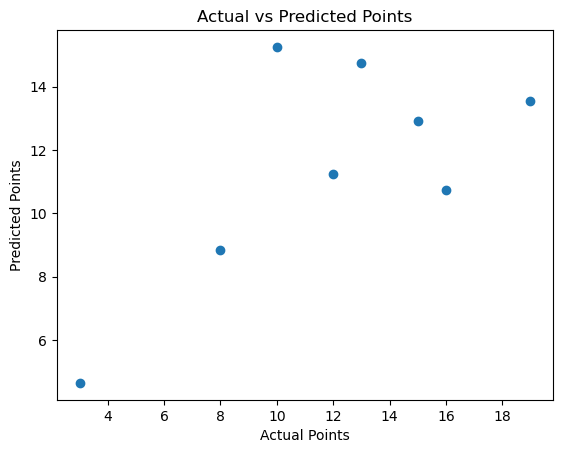

In [49]:
# ----- Regression -----
# Feature Engineering
ayo_merged_df["Last_5_Game_Avg"] = ayo_merged_df["PTS"].rolling(window=5, min_periods=1).mean()
ayo_merged_df["Minutes_Per_Point"] = ayo_merged_df["MIN"] / ayo_merged_df["PTS"]
ayo_merged_df.fillna(0, inplace=True)  # Fill NaNs after rolling averages

# Select features and target variable
features = ["MIN", "AST", "REB", "Last_5_Game_Avg", "Minutes_Per_Point"]
X = ayo_merged_df[features]
y = ayo_merged_df["PTS"]  # Target: Points scored

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Visualization
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")
plt.title("Actual vs Predicted Points")
plt.show()

### Dashboard & Visualization

### Conclusion